### Modelling
1. connect the drive and read datasets.
2. data preprocessing
3. modelling
* Liner Regression
* Random Forest Regression
* Ridge Regression
* KNN Regression
* Lasso Regression
* Support Vector Regression



In [ ]:
import random
import pandas as pd

from google.colab import drive
from sklearn.svm import SVR
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

#加载drive文件
drive.mount('/content/drive') #connect the drive
dataset_file = '/content/drive/MyDrive/W-Workspace/MovieLens_da_li/dataset'

Mounted at /content/drive


## Data Preprocessing

In [ ]:
# 参数设定，数据准备
import numpy as np

df = pd.read_csv(dataset_file + '/dataset.csv', sep=',')
seed = 42
np.random.seed(seed)
random.seed(seed)
apply_pca=False

In [ ]:
from sklearn.model_selection import train_test_split

#split data and labels  分离特征和标签
X = df.drop(['rating'], axis=1) # 特征fature，除了rating以外的其他变量
y = df['rating'] # 标签label, rating

# 划分数据集
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # train_size=0.8*0.9,
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

#count the numebr of x_train x_val and x_test  打印各数据集的大小
print("Number of training set: ", X_train.shape[0])
print("Number of validation set: ", X_val.shape[0])
print("Numebr of testing set: ", X_test.shape[0])

Number of training set:  9946
Number of validation set:  1106
Numebr of testing set:  2764


In [ ]:
if apply_pca:
    try:
        pca = PCA(n_components=0.95)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_val = pca.transform(X_val)
        X_test = pca.transform(X_test)
        print("PCA applied to the dataset")
    except Exception as e:
        print("Error occurred while applying PCA:", e)
else:
    print("PCA was not applied to the dataset")

PCA was not applied to the dataset


##Liner Regression

### PCA:

* Mean Square Error: 0.0064
* R-square: 0.9709

### No_PCA:
* Mean Square Error: 0.0054
* R2-square: 0.9754

In [ ]:
import os
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.tensorboard import SummaryWriter

base_dir = '/content/drive/MyDrive/W-Workspace/MovieLens_da_li/'  # Google Drive 根目录
log_name = "linear_regression"
log_dir = os.path.join(base_dir, "results", "TML", "pca" if apply_pca else "no_pca", "LinearRegression", log_name)
writer = SummaryWriter(log_dir)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
y_pred = lin_regr.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print('Mean Square Error:', mse)
writer.add_scalar('Loss/MSE', mse)
writer.flush()

# 计算 R2 分数
rsquare = r2_score(y_test, y_pred)
print('R2-square:', rsquare)

# 确保关闭 writer
writer.close()

Mean Square Error: 0.0054454069190485845
R2-square: 0.9754341910082424


## Random Forest Regressor
### PCA:
* Mean Squared Error:  0.0373
* R2 Score:  0.8315

### No PCA:
* Mean Square Error:  0.0125
* R2 Score:  0.9433

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": [10, 15, 20, 25, 30],
    "criterion": ["squared_error", "friedman_mse"]
}
rf = RandomForestRegressor()

try:
    print(X_train.shape)
    print(y_train.shape)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_hyper = grid_search.best_params_
    print("Best hyperpara meters: ", best_hyper)
except Exception as e:
    print("An error occurred:", e)

(9946, 1128)
(9946,)
Best hyperparameters:  {'criterion': 'friedman_mse', 'n_estimators': 30}


In [ ]:
# 打印 apply_pca 的值
print(apply_pca)

# 定义基础路径和文件名
base_dir = '/content/drive/MyDrive/W-Workspace/MovieLens_da_li/'
base_path = base_dir + "results/TML/cv_results"
file_name = "RandomForestRegressor.csv"
print(base_path)


# 根据 apply_pca 选择子路径
sub_path = "pca" if apply_pca else "no_pca"

# 完整的文件路径
full_path = os.path.join(base_path, sub_path, file_name)

# 尝试写入文件
try:
    pd.DataFrame(grid_search.cv_results_).to_csv(full_path)
    print(f"Saved to {full_path}")
except Exception as e:
    print(f"Error saving file: {e}")

False
/content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/cv_results
Saved to /content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/cv_results/no_pca/RandomForestRegressor.csv


In [ ]:
# 提取结果并转换为正值
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_estimators', 'param_criterion', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

# 初始化 TensorBoard 写入器
base_dir = '/content/drive/MyDrive/W-Workspace/MovieLens_da_li/'
sub_dir = "pca" if apply_pca else "no_pca"
log_dir = os.path.join(base_dir, "results", "TML", sub_dir, "RandomForest")
print(log_dir)

writer = SummaryWriter(log_dir)

# 将结果记录到 TensorBoard
try:
    for index, row in results.iterrows():
        mse = row['mean_test_score']
        n_estimators = row['param_n_estimators']
        criterion = row['param_criterion']
        writer.add_hparams({"n_estimators": n_estimators, "criterion": criterion}, {"hparam/mse": mse})
        writer.flush()
finally:
    writer.close()

/content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/no_pca/RandomForest


In [ ]:
# 将最佳参数转换为 DataFrame 并转置
rf = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value']).T

# 构造文件保存路径
base_dir = '/content/drive/MyDrive/W-Workspace/MovieLens_da_li/'
sub_dir = "pca" if apply_pca else "no_pca"
file_path = os.path.join(base_dir, "results", 'TML', 'best_params', sub_dir, 'random_forest.csv')

# 尝试保存到 CSV 文件
try:
    rf.to_csv(file_path, index=False)
    print(f"Best parameters saved to {file_path}")
except Exception as e:
    print(f"Error saving file: {e}")

Best parameters saved to /content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/best_params/no_pca/random_forest.csv


In [ ]:
# 创建并训练随机森林模型
rf = RandomForestRegressor(criterion='friedman_mse', n_estimators=30).fit(X_train, y_train)

# 在测试集上进行预测
y_pred = rf.predict(X_test)

# 计算并打印性能指标
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  0.012738678622681958
R2 Score:  0.9425321283598643


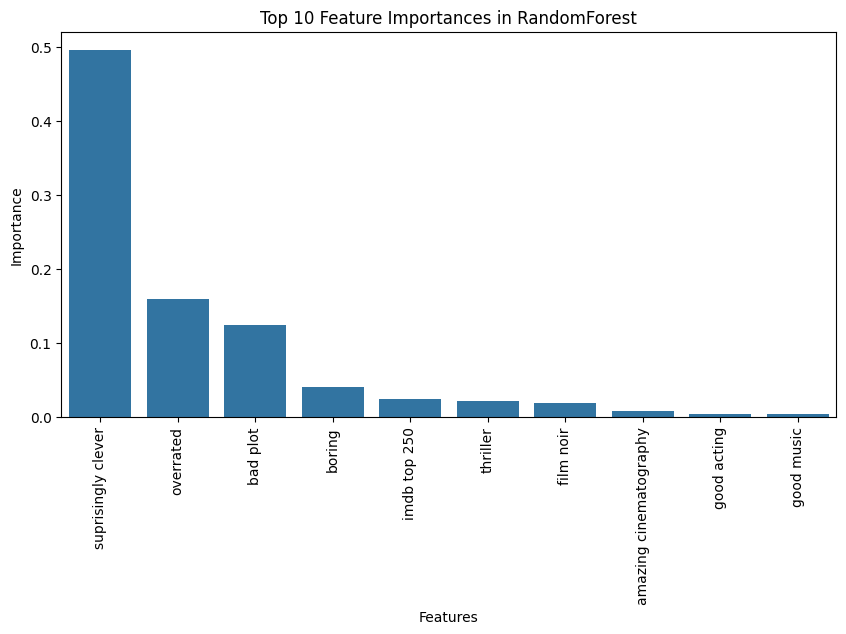

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if not apply_pca:
    # 获取特征重要性并排序
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    features = X.columns

    # 绘制特征重要性图
    plt.figure(figsize=(10, 5))
    sns.barplot(x=features[indices[0:10]], y=importances[indices[0:10]])
    plt.title("Top 10 Feature Importances in RandomForest")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.xticks(rotation=90)
    plt.show()
else:
    print("PCA is applied, so no feature importance graph is shown")


## Ridge Regressor
### PCA:
* Mean Squared Error:  0.0063
* R2 Score:  0.9711

### NO PCA:
* Mean Square Error: 0.0053
* R2 Score:  0.9759

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

param_grid = {"alpha": [0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20]}
ridge = Ridge()

try:
    grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_hyper = grid_search.best_params_
    print("Best hyperparameters: ", best_hyper)
except Exception as e:
    print("An error occurred during GridSearchCV fitting:", e)

Best hyperparameters:  {'alpha': 5}


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import os

# 根据 apply_pca 选择子目录
base_path = base_dir + "results/TML/cv_results"
sub_dir = "pca" if apply_pca else "no_pca"
log_dir = os.path.join(base_path, sub_dir, "Ridge")

# 初始化 TensorBoard 写入器
writer = SummaryWriter(log_dir)

In [ ]:
# 提取结果并转换为正值
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

# 初始化 TensorBoard 写入器
base_path = base_dir + "results/TML/cv_results"
sub_dir = "pca" if apply_pca else "no_pca"
log_dir = os.path.join(base_path, sub_dir, "Ridge")
writer = SummaryWriter(log_dir)

# 将结果记录到 TensorBoard
for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha}, {"mse": mse})
    writer.flush()

# 关闭 TensorBoard 写入器
writer.close()

In [ ]:
# 将最佳参数转换为 DataFrame 并转置
ridge_params = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value']).T

# 构造文件保存路径
base_path = base_dir + "results/TML/cv_results"
sub_dir = "pca" if apply_pca else "no_pca"
file_path = os.path.join(base_path, sub_dir, 'ridge.csv')

# 尝试保存到 CSV 文件
try:
    ridge_params.to_csv(file_path, index=False)
    print(f"Best parameters saved to {file_path}")
except Exception as e:
    print(f"Error saving file: {e}")

Best parameters saved to /content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/cv_results/no_pca/ridge.csv


In [ ]:
try:
    # 使用最佳参数创建并训练 Ridge 模型
    optimized_ridge = Ridge(**best_hyper)
    optimized_ridge.fit(X_train, y_train)

    # 在测试集上进行预测
    y_pred = optimized_ridge.predict(X_test)

    # 计算并打印性能指标
    print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
    print("R2 Score: ", r2_score(y_test, y_pred))
except Exception as e:
    print("An error occurred:", e)

Mean Squared Error:  0.005323110704793609
R2 Score:  0.9759859046789496


## KNN Regressor
### PCA:
* Mean Squared Error:  0.0402
* R2 Score:  0.8182

### No PCA:
* Mean Square Error: 0.0405
* R2 Score:  0.8172

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {
    'n_neighbors': [7, 8, 9, 10, 15, 20],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsRegressor()

try:
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_hyper = grid_search.best_params_
    print("Best hyperparameters: ", best_hyper)
except Exception as e:
    print("An error occurred during GridSearchCV fitting:", e)

Best hyperparameters:  {'n_neighbors': 10, 'weights': 'distance'}


In [ ]:
# 构造文件保存路径

base_path = base_dir + "results/TML/cv_results"
sub_dir = "pca" if apply_pca else "no_pca"
file_path = os.path.join(base_path, sub_dir, "KNN.csv")

# 尝试将结果保存到 CSV 文件
try:
    pd.DataFrame(grid_search.cv_results_).to_csv(file_path)
    print(f"CV results saved to {file_path}")
except Exception as e:
    print(f"Error saving CV results: {e}")


CV results saved to /content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/cv_results/no_pca/KNN.csv


In [ ]:
from torch.utils.tensorboard import SummaryWriter

# 提取并转换结果
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_neighbors', 'param_weights', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1

# 条件初始化 TensorBoard 写入器
log_dir = base_dir + "results/TML/pca/KNN/" if apply_pca else base_dir + "results/TML/no_pca/KNN/"
writer = SummaryWriter(log_dir)

# 记录超参数和性能指标到 TensorBoard
for index, row in results.iterrows():
    mse = row['mean_test_score']
    n_neighbors = row['param_n_neighbors']
    weights = row['param_weights']
    writer.add_hparams({"n_neighbors": n_neighbors, "weights": weights}, {"hparam/mse": mse})
    writer.flush()

# 关闭 TensorBoard 写入器
writer.close()


In [ ]:
knn = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
knn = knn.T
if apply_pca == True:
    knn.to_csv(base_dir + 'results/TML/best_params/pca/knn.csv', index=False)
else:
    knn.to_csv(base_dir + 'results/TML/best_params/no_pca/knn.csv', index=False)


In [ ]:
knn = KNeighborsRegressor(**best_hyper)
knn.fit(X_train, y_train)
y_pred= knn.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))


Mean Squared Error:  0.04050348852249125
R2 Score:  0.8172770231251678


## Lasso Regressor
### PCA:
* Mean Squared Error:  0.0064
* R2 Score:  0.9710

### No PCA:
* Mean Squared Error: 0.0054
* R2 Score:  0.9755

In [ ]:
param_grid = {
                'alpha':[1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
              }
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train,y_train)
best_hyper= grid_search.best_params_
print("Best hyper: ", best_hyper)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.527e+00, tolerance: 1.880e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.996e+00, tolerance: 1.910e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.742e+00, tolerance: 1.920e

Best hyper:  {'alpha': 1e-05}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+01, tolerance: 2.373e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# 选择文件夹基于是否应用了 PCA
folder = 'pca' if apply_pca else 'no_pca'

# 构建文件路径
file_path = os.path.join(base_dir, 'results', 'TML', 'cv_results', folder, 'Lasso.csv')

# 保存网格搜索结果到 CSV 文件
pd.DataFrame(grid_search.cv_results_).to_csv(file_path)

print(f"网格搜索结果已保存到: {file_path}")

网格搜索结果已保存到: /content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/cv_results/no_pca/Lasso.csv


In [ ]:
# 转换 mean_test_score 并选择相关列
results = pd.DataFrame(grid_search.cv_results_)[['param_alpha', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'].abs()  # 直接取绝对值

# 确定 TensorBoard 写入目录
log_dir = base_dir + "results/TML/pca/Lasso/" if apply_pca else "results/TML/no_pca/Lasso/"
writer = SummaryWriter(log_dir)

# 批量记录超参数和指标到 TensorBoard
for index, row in results.iterrows():
    writer.add_hparams({"alpha": row['param_alpha']}, {"hparam/mse": row['mean_test_score']})
writer.close()

In [ ]:
# 将最佳参数转换为 DataFrame 并转置
lasso = pd.DataFrame([grid_search.best_params_])

# 根据是否应用 PCA 动态确定保存路径
folder = 'pca' if apply_pca else 'no_pca'
file_path = os.path.join(base_dir, 'results', 'TML', 'best_params', folder, 'lasso.csv')

# 确保目录存在
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# 保存 DataFrame 到 CSV 文件
lasso.to_csv(file_path, index=False)

print(f"最佳参数已保存到: {file_path}")

最佳参数已保存到: /content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/best_params/no_pca/lasso.csv


In [ ]:
lasso = Lasso(**best_hyper)
lasso.fit(X_train, y_train)
y_pred= lasso.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  0.005423553353396875
R2 Score:  0.9755327787772686


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+01, tolerance: 2.373e-01
  model = cd_fast.enet_coordinate_descent(


In [ ]:
if not apply_pca:
    # 假设 lasso 是已训练好的 Lasso 模型，X 是特征 DataFrame，y 是目标变量 Series
    lasso_coef = pd.DataFrame(lasso.coef_, index=X.columns, columns=['value'])
    zero_coef = lasso_coef[lasso_coef['value'] == 0]
    print("Number of features that are zero: ", len(zero_coef))

    # 计算系数为零的特征与y的相关性
    X_zero_coef = X[zero_coef.index]
    corr = X_zero_coef.corrwith(y)
    display(corr.head(10))

Number of features that are zero:  146


007           -0.097706
1920s          0.379278
3d            -0.153728
aardman        0.060788
afterlife     -0.079177
alcoholism     0.206545
almodovar      0.083976
amnesia        0.062696
animation      0.024383
arms dealer   -0.073337
dtype: float64

## SVR
### PCA:
* Mean Squared Error: 0.0064
* R2 Score: 0.9708

### No PCA:
* Mean Squared Error: 0.0054
* R2 Score: 0.9754

In [ ]:
# 定义参数网格
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'epsilon': [0.001, 0.01, 0.1, 1]
}

# 初始化 SVR
svr = SVR()

# 执行网格搜索
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

# 获取并打印最佳超参数
best_hyper = grid_search.best_params_
print("Best hyperparameters:", best_hyper)

# 打印最佳得分
best_score = np.sqrt(-grid_search.best_score_)  # 将得分转换为正值并开平方
print("Best score (RMSE):", best_score)

Best hyperparameters: {'epsilon': 0.001, 'kernel': 'rbf'}
Best score (RMSE): 0.07442577751016524


In [ ]:
# 确定文件保存的路径
folder = "pca" if apply_pca else "no_pca"
file_path = os.path.join(base_dir, "results", "TML", "cv_results", folder, "SVR.csv")

# 确保目标目录存在
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# 保存 GridSearchCV 的结果到 CSV 文件
pd.DataFrame(grid_search.cv_results_).to_csv(file_path)

print(f"GridSearchCV 的结果已保存到: {file_path}")

GridSearchCV 的结果已保存到: /content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/cv_results/no_pca/SVR.csv


In [ ]:
# 转换 mean_test_score 并选择相关列
results = pd.DataFrame(grid_search.cv_results_)[['param_kernel', 'param_epsilon', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'].abs()  # 将负 MSE 转换为正值

# 确定 TensorBoard 写入目录
log_dir = os.path.join(base_dir, "results", "TML", "pca" if apply_pca else "no_pca", "SVR")
writer = SummaryWriter(log_dir)

# 批量记录超参数和指标到 TensorBoard
for index, row in results.iterrows():
    writer.add_hparams(
        {"kernel": row['param_kernel'], "epsilon": row['param_epsilon']},
        {"hparam/mse": row['mean_test_score']}
    )

writer.close()

In [ ]:
# 将最佳参数转换为 DataFrame
svr = pd.DataFrame([grid_search.best_params_])

# 根据是否应用了 PCA 构建文件路径
folder = 'pca' if apply_pca else 'no_pca'
file_path = os.path.join(base_dir, 'results', 'TML', 'best_params', folder, 'svr.csv')

# 确保目录存在
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# 保存 DataFrame 到 CSV 文件
svr.to_csv(file_path, index=False)

print(f"SVR 最佳参数已保存到: {file_path}")

SVR 最佳参数已保存到: /content/drive/MyDrive/W-Workspace/MovieLens_da_li/results/TML/best_params/no_pca/svr.csv


In [ ]:
svr = SVR(**best_hyper)
svr.fit(X_train, y_train)
y_pred= svr.predict(X_test)

print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

Mean Squared Error:  0.005214488613478727
R2 Score:  0.9764759304175574
